[Notebook of task](https://github.com/DistributedSystemsGroup/Algorithmic-Machine-Learning/blob/master/Challenges/Anomaly_Detection/anomaly_detection_challenge.ipynb)

In [2]:
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

basepath = "/mnt/datasets/anomaly/"

In [3]:
column_names = [
    "SessionNumber", 
    "SystemID",
    "Date",
    "HighPriorityAlerts", 
    "Dumps",
    "CleanupOOMDumps",
    "CompositeOOMDums",
    "IndexServerRestarts",
    "NameServerRestarts",
    "XSEngineRestarts",
    "PreprocessorRestarts",
    "DaemonRestarts",
    "StatisticsServerRestarts",
    "CPU",
    "PhysMEM",
    "InstanceMEM",
    "TablesAllocation", 
    "IndexServerAllocationLimit",
    "ColumnUnloads",
    "DeltaSize",
    "MergeErrors",
    "BlockingPhaseSec", 
    "Disk",
    "LargestTableSize",
    "LargestPartitionSize",
    "DiagnosisFiles",
    "DiagnosisFilesSize",
    "DaysWithSuccessfulDataBackups",
    "DaysWithSuccessfulLogBackups",
    "DaysWithFailedDataBackups",
    "DaysWithFailedfulLogBackups",
    "MinDailyNumberOfSuccessfulDataBackups",
    "MinDailyNumberOfSuccessfulLogBackups",
    "MaxDailyNumberOfFailedDataBackups",
    "MaxDailyNumberOfFailedLogBackups",
    "LogSegmentChange",
    "Check1",
    "Check2",
    "Check3",
    "Check4",
    "Check5",
    "Check6",
    "Check7",
    "Check8"
]

labels = ["Check1", "Check2", "Check3", "Check4", "Check5", "Check6", "Check7", "Check8"]

In [4]:
dataDF = pd.read_csv(basepath + 'data.csv', delimiter=";", header=None, names=column_names)

In [5]:
dataDF.head()

,SessionNumber,SystemID,Date,HighPriorityAlerts,Dumps,CleanupOOMDumps,CompositeOOMDums,IndexServerRestarts,NameServerRestarts,XSEngineRestarts,...,MaxDailyNumberOfFailedLogBackups,LogSegmentChange,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0,0,0,16/01/2017 04:04,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
1,1,1,06/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
2,2,1,20/02/2017 04:03,0,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
3,3,2,13/02/2017 04:44,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0
4,4,3,06/02/2017 04:31,1,0.0,0.0,0.0,0,0,0,...,0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,0.0


In [6]:
# create pure data DF
puredataDF = dataDF.drop(labels, axis=1)

#create a copy of the label columns for exploration
anomaliesDF = dataDF.filter(labels, axis=1)

# percentage of NA in each label 
print(anomaliesDF.isna().mean().round(4) * 100) 

anomaliesDF_withoutNA = anomaliesDF.fillna(0)

Check1     8.54
Check2     8.53
Check3     7.86
Check4    12.77
Check5    12.21
Check6     2.57
Check7    12.45
Check8     0.02
dtype: float64


The different labels have a lot of NaN values. Should these be removed? Or should we handle each label individually and only use the rows without NaNs for that label? The simplest solution is to fill them with 0's.

Text(0.5,1,'Corrolation matrix of the 8 different labels')

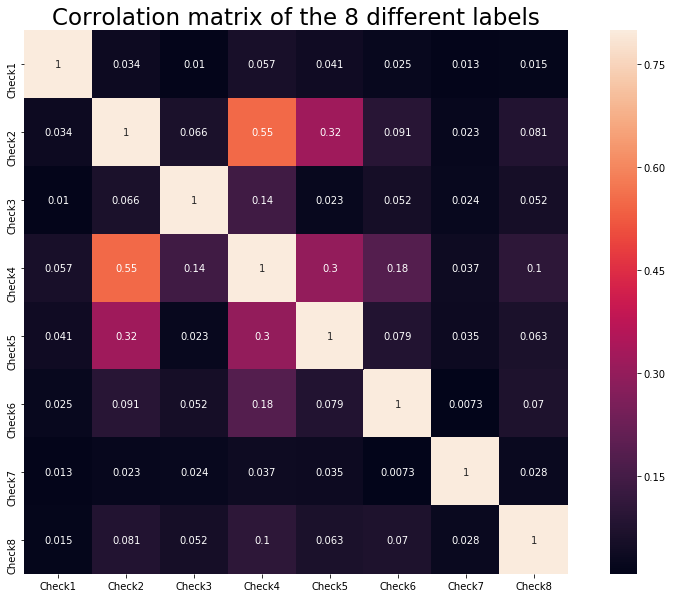

In [7]:
#sns.set(font_scale=1.3)

corr_matrix_anomalies = anomaliesDF.corr()
figure, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_matrix_anomalies, vmax=0.8, annot=True, square=True)
plt.title('Corrolation matrix of the 8 different labels', fontsize=23)


### Things to note from corr matrix of the different labels
- Check4 and Check2 have a corrolation of 0.55. It could be wise to make one model to predict these two together.
- Check5 and Check2 have a corrolation of 0.32
- Check5 and Check4 have a corrolation of 0.3
- Maybe all three together?

In [8]:
#counted_anomaliesDF = anomaliesDF_withoutNA.apply(pd.value_counts)
counted_anomaliesDF = anomaliesDF.apply(pd.value_counts)

In [9]:
counted_anomaliesDF.loc["Total"] = counted_anomaliesDF.sum()
counted_anomaliesDF.loc["PercentageAnomalies"] = (counted_anomaliesDF.iloc[1] / counted_anomaliesDF.iloc[2]).round(5)*100


In [10]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

counted_anomaliesDF

,Check1,Check2,Check3,Check4,Check5,Check6,Check7,Check8
0.0,260884.00,253781.00,256370.00,225569.00,248917.00,199075.00,243621.00,284060.00
1.0,1636.00,8764.00,8093.00,24815.00,3080.00,80572.00,7688.00,2919.00
Total,262520.00,262545.00,264463.00,250384.00,251997.00,279647.00,251309.00,286979.00
PercentageAnomalies,0.62,3.34,3.06,9.91,1.22,28.81,3.06,1.02


Text(0.5,1,'Number of observations with one or more anomaly')

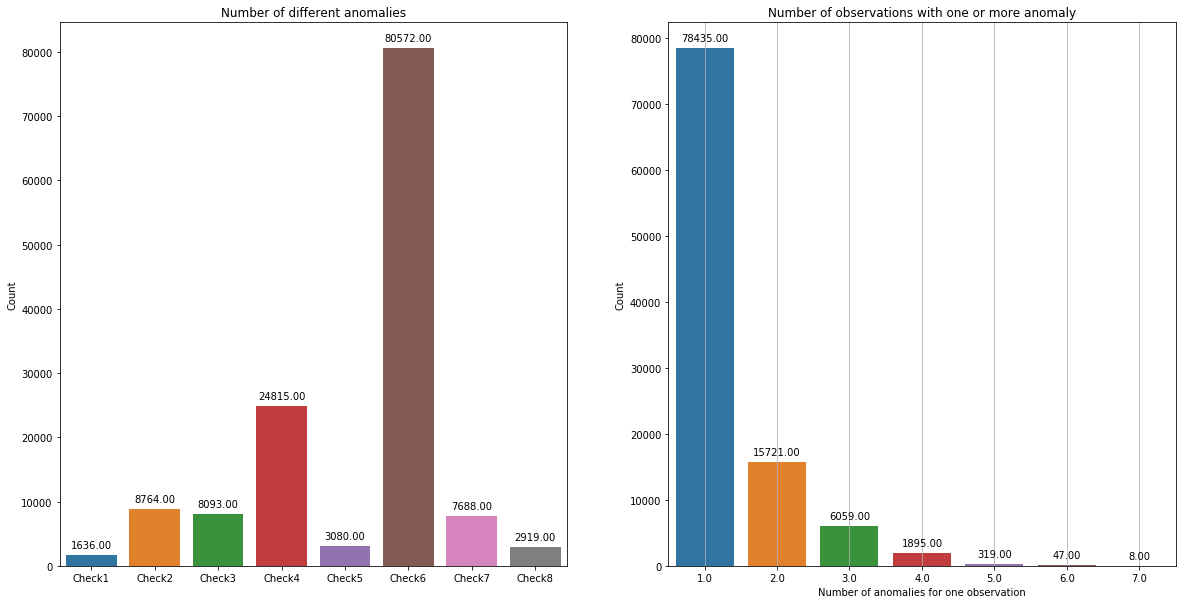

In [59]:
y1 = counted_anomaliesDF.loc[1.0]
x1 = labels

rowSums = dataDF.iloc[:,36:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

figure = plt.figure(figsize=(20,10))
ax1 = figure.add_subplot(1,2,1)
ax2 = figure.add_subplot(1,2,2)

b1 = sns.barplot(y=y1, x=x1, ax=ax1)
plt.grid()

for p in b1.patches:
    b1.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

b2 = sns.barplot(x=multiLabel_counts.index, y=multiLabel_counts.values, ax=ax2)
plt.grid()

for p in b2.patches:
    b2.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')

ax1.set_ylabel('Count')
ax1.set_title('Number of different anomalies')

ax2.set_xlabel('Number of anomalies for one observation')
ax2.set_ylabel('Count')
ax2.set_title('Number of observations with one or more anomaly')

## Exploration of data (not labels)

In [14]:
# percentage of NA in each label 
print(puredataDF.isna().mean().round(4) * 100) 

SessionNumber                            0.00
SystemID                                 0.00
Date                                     0.00
HighPriorityAlerts                       0.00
Dumps                                    0.00
CleanupOOMDumps                          0.00
CompositeOOMDums                         0.00
IndexServerRestarts                      0.00
NameServerRestarts                       0.00
XSEngineRestarts                         0.00
PreprocessorRestarts                     0.00
DaemonRestarts                           0.00
StatisticsServerRestarts                 0.00
CPU                                      8.78
PhysMEM                                  7.17
InstanceMEM                              7.71
TablesAllocation                         0.80
IndexServerAllocationLimit               9.21
ColumnUnloads                            0.00
DeltaSize                                0.07
MergeErrors                              2.69
BlockingPhaseSec                  

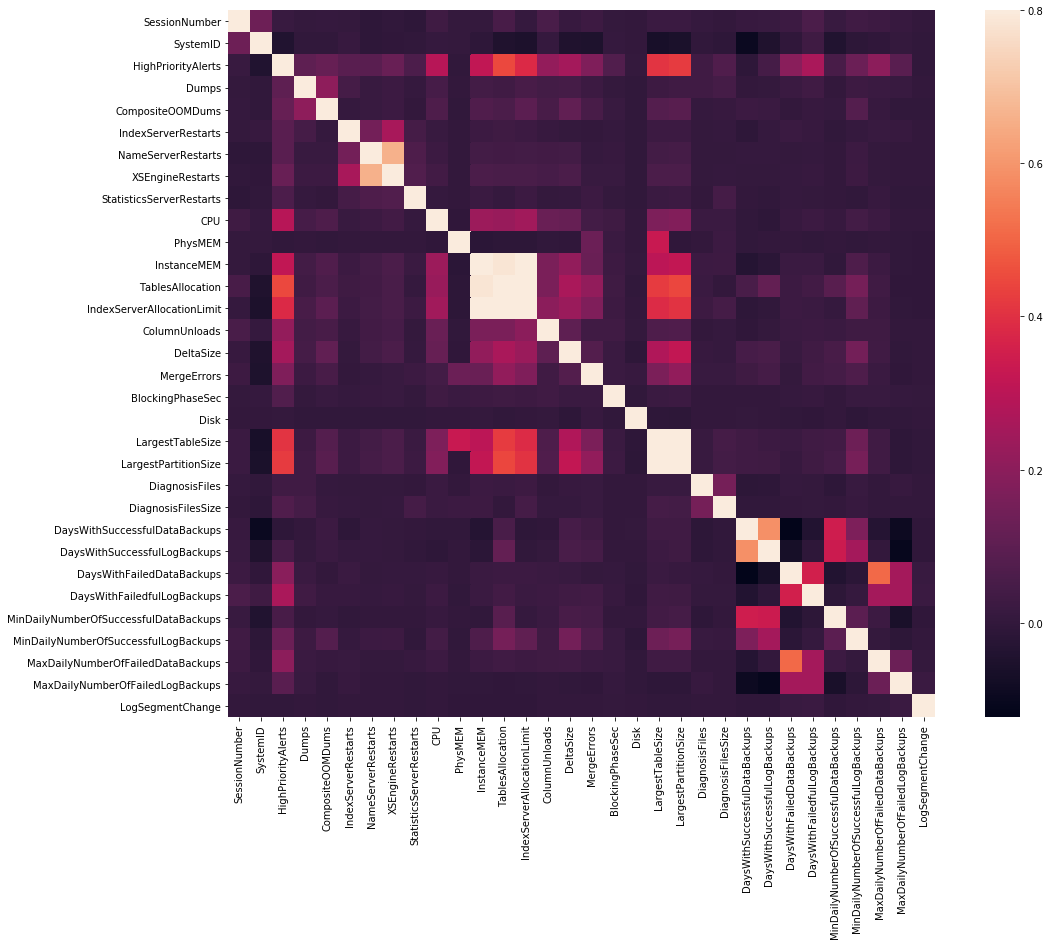

In [37]:
matrixDF = puredataDF.drop(["CleanupOOMDumps","PreprocessorRestarts", "DaemonRestarts"], axis=1)
corr_matrix_puredata = matrixDF.corr()
figure, ax = plt.subplots(figsize=(18,13))
ax = sns.heatmap(corr_matrix_puredata, vmax=0.8, square=True)


# Data preprocessing

In [14]:
puredataDF.dtypes

SessionNumber                              int64
SystemID                                   int64
Date                                      object
HighPriorityAlerts                         int64
Dumps                                    float64
CleanupOOMDumps                          float64
CompositeOOMDums                         float64
IndexServerRestarts                        int64
NameServerRestarts                         int64
XSEngineRestarts                           int64
PreprocessorRestarts                       int64
DaemonRestarts                             int64
StatisticsServerRestarts                   int64
CPU                                      float64
PhysMEM                                  float64
InstanceMEM                              float64
TablesAllocation                         float64
IndexServerAllocationLimit               float64
ColumnUnloads                              int64
DeltaSize                                float64
MergeErrors         

In [17]:
#not_applicable_labels = labels + ["Date"]
#cols = [x for x in column_names if x not in not_applicable_labels]
cols = ["IndexServerRestarts", "NameServerRestarts", "XSEngineRestarts","PreprocessorRestarts""DaemonRestarts","StatisticsServerRestarts"]
df = puredataDF.filter(["IndexServerRestarts", "NameServerRestarts", "XSEngineRestarts","PreprocessorRestarts","DaemonRestarts","StatisticsServerRestarts"], axis=1)
#df.fillna(df.median(), inplace=True)


In [ ]:
from sklearn.ensemble import IsolationForest

fig, axs = plt.subplots(1, 6, figsize=(25, 25), facecolor='w', edgecolor='k')
axs = axs.ravel()

for i, column in enumerate(cols):
    isolation_forest = IsolationForest(contamination='auto')
    isolation_forest.fit(df[column].values.reshape(-1,1))

    xx = np.linspace(df[column].min(), df[column].max(), len(df)).reshape(-1,1)
    anomaly_score = isolation_forest.decision_function(xx)
    outlier = isolation_forest.predict(xx)
    
    axs[i].plot(xx, anomaly_score, label='anomaly score')
    axs[i].fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                     where=outlier==-1, color='r', 
                     alpha=.4, label='outlier region')
    axs[i].legend()
    axs[i].set_title(column)



# Modeling

- https://towardsdatascience.com/journey-to-the-center-of-multi-label-classification-384c40229bff


### Multi-label classification
- Decide Evaluation Metric
   - F1 Macro/Micro
   - Hamming-Loss
   - Exact Match Ratio
- Several binary classifiers vs. one multi-label
    - OnevsRest
    - Binary Relevance
    - Classifier Chains
    - Label Powerset
    - Adapted Algorithm